 * In this project I am going to predict the price of used cars using Random Forest, Linear regression, Lasso and Ridge            regression and Decision tree.
 * Data is collected from Kaggle.
 * I used python for Data cleaning, Data pre-processing, seaborn and Matplotlib for Visualisation, Scikit learn for building       the machine learning models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
data = pd.read_csv('C:\\Users\\srt90\\Desktop\\Used car project\\craigslistVehicles.csv')

In [4]:
data.head()

,url,city,city_url,price,year,manufacturer,make,condition,cylinders,fuel,...,transmission,VIN,drive,size,type,paint_color,image_url,desc,lat,long
0,https://abilene.craigslist.org/cto/d/aspermont...,"abilene, TX",https://abilene.craigslist.org,9000,2009.0,chevrolet,suburban lt2,good,8 cylinders,gas,...,automatic,1GFNC26099R211276,rwd,full-size,SUV,white,https://images.craigslist.org/00909_5P6f1E6zHl...,2WD 1/2 ton\nLeather Captains Chairs\nIn good ...,33.130100,-100.234400
1,https://abilene.craigslist.org/ctd/d/liberty-h...,"abilene, TX",https://abilene.craigslist.org,31999,2012.0,ram,2500,NaN,NaN,diesel,...,automatic,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00u0u_24XW8uhLYP...,www.GETADIESEL.com\n2012 RAM 2500 SLT 4X4 MEGA...,30.648368,-97.862949
2,https://abilene.craigslist.org/ctd/d/liberty-h...,"abilene, TX",https://abilene.craigslist.org,16990,2003.0,ram,3500,NaN,NaN,diesel,...,manual,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00l0l_H1UKTJ4sTI...,www.GETADIESEL.com\n2003 DODGE RAM 3500 LARAMI...,30.648516,-97.862434
3,https://abilene.craigslist.org/cto/d/merkel-20...,"abilene, TX",https://abilene.craigslist.org,6000,2002.0,gmc,sierra 1500,good,8 cylinders,gas,...,automatic,NaN,4wd,NaN,pickup,white,https://images.craigslist.org/00M0M_2wKzc7dKLU...,2002 GMC Sierra Extended Cab Truck For Sale! R...,32.444400,-99.992400
4,https://abilene.craigslist.org/cto/d/breckenri...,"abilene, TX",https://abilene.craigslist.org,37000,2012.0,chevrolet,3500,excellent,8 cylinders,diesel,...,automatic,NaN,4wd,full-size,pickup,silver,https://images.craigslist.org/00r0r_eW1YWlKfCG...,"2012 Chevrolet 3500 178k miles, runs and drive...",32.781689,-98.942248


In [5]:
# copy
new_data = data.copy()

In [6]:
new_data.shape

(550313, 22)

## **Data Cleaning**

In [7]:
#re-naming the columns
new_data.rename({'make': 'model', 'odometer': 'mileage'}, axis= 1,inplace= True)

In [8]:
# Lets drop the columns that are not useful for the car price prediction.
drop_columns = ['city_url', 'url','lat','long','image_url', 'VIN', 'city']
new_data = new_data.drop(drop_columns, axis =1)
new_data.shape

(550313, 15)

In [9]:
#lets drop the columns where price of the car is more than 2.5 million dollars because high end used cars like ferrari, porsche costs less than that
new_data = new_data.drop(new_data[new_data.price > 250000].index)
new_data.shape

(550177, 15)

In [10]:
#Lets drop the columns where year is less than 1990 and greater than 2019
new_data = new_data[(new_data['year'] > 1990) & (new_data['year'] < 2020)]
new_data.index = range(len(new_data))
new_data.shape

(527135, 15)

In [11]:
# finding the length of description of each car
new_data.dropna(subset = ['desc'],inplace = True) # dropping the null values in 'desc' column
new_data['word_len'] = new_data.desc.apply(lambda x: len(str(x.lower().split())))
new_data.index = range(len(new_data))
del new_data['desc']

In [12]:
#finding the age of car
from datetime import datetime

current_year = datetime.now().year
new_data['Age'] = current_year - new_data['year']
del new_data['year']

In [13]:
# removing the 'cylinders' in the columns and converting into float.
new_data.cylinders = new_data.cylinders.apply(lambda x: x if str(x).lower()[-1] == 'o' or str(x).lower()[-1] == 'n' else str(x).lower().replace('cylinders', ''))
new_data.cylinders = pd.to_numeric(new_data.cylinders, errors = 'coerce')
new_data.cylinders.fillna(new_data.cylinders.median(), inplace = True)

In [14]:
# Lets drop the rows where has atleast 3 NaN values.
new_data.dropna(thresh = 13, axis = 0, inplace = True)
new_data.shape

(324833, 15)

In [15]:
#dropping the duplicates in the data
new_data.drop_duplicates(keep = 'first', inplace = True)
new_data.index = range(len(new_data))
new_data.shape

(251722, 15)

In [16]:
# fixing the spelling errors
new_data.manufacturer = new_data.manufacturer.apply(lambda x: x.replace('porche', 'porsche') if x == 'porche' else x)

In [17]:
# creating new dataframe to find the size of each car in order to fill the null values in the size feature of same car
new = new_data.sort_values(by= ['size','manufacturer','type'])
new.drop_duplicates(subset = ['model','type'], keep = 'first', inplace = True)
new.index = range(len(new))

In [18]:
new.dropna(subset = ['size','model'], inplace= True)
new.index = range(len(new))

In [19]:
# dictionary that contain size of each car
size = dict(zip(new['model'], new['size']))
for i in range(len(new_data)):
    if str(new_data['size'][i]).lower()[0] == 'n' and (new_data['model'][i] in size.keys()):
        new_data['size'][i] = size[new_data['model'][i]]

C:\Users\srt90\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [20]:
# Adding the manufacturers name to list from the dataset and adding few more manufacturer after looking the make column in dataset
manuf = []
for i in new_data.manufacturer.value_counts().index:
    manuf.append(i)
manuf.append('Tesla')
manuf.append('Rolls-Royce')
manuf.append('genesis')

In [21]:
# Replace the nan values in the manufacturer column based on the model column 
# from make column we can identify manufacturer of the car as it sometimes contains the manufacturer name in it
d = new_data['manufacturer']
m = new_data['model']
for i in range(len(new_data)):
    if str(d[i]).lower()[0] == 'n':
        for x in str(m[i]).lower().split():
            for mm in manuf:
                if (len(x) > 4) & (x[:4] == mm.lower()[:4]):
                    new_data['manufacturer'][i] = mm
                elif (x[:3] == mm.lower()[:3]) & (x[:-1] == mm.lower()[:-1]):
                    new_data['manufacturer'][i] = mm

C:\Users\srt90\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\srt90\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [22]:
# reduce the paint color feature to common and not common colors
common_colors = list(['white','grey','black','silver','blue','red'])
new_data['paint_color'] = new_data['paint_color'].apply(lambda x: 'Common' if x in common_colors else 'Not_common')

In [23]:
#dropping the null values
new_data.dropna(subset = ['transmission','type','manufacturer','model','fuel','mileage','title_status','paint_color','drive','size','condition'],inplace = True)
new_data.index = range(len(new_data))
new_data.shape

(137646, 15)

In [24]:
# Function to remove the outliers in the data
def outlier_removal(x):
    for i in x:
        z_score_od = np.abs(stats.zscore(new_data[i]))
        outliers = np.where(z_score_od > 3)
        new_data.drop(new_data.index[[i for i in outliers[0]]],inplace= True)
        new_data.index = range(len(new_data))  
        
outlier_removal(new_data._get_numeric_data().columns)

In [25]:
# price of car cant be zero so we are eliminating the price less than 50 dollars. Some people mention very less price and 
# they will reveal the price directly to customer while buying and bargain later.
new_data = new_data[new_data['price'] > 50]
new_data.index = range(len(new_data))
new_data.shape

(125788, 15)

In [26]:
#shifting the 'age' to new place
new_data.insert(1, 'age', new_data['Age'])
del new_data['Age']

In [27]:
# creating the dictionary for integer labelling
cond_dict = {'new':10, 'like new':9, 'excellent':8, 'good':7, 'fair':5, 'salvage':3}
title_dict = {'clean': 6, 'lien': 4, 'rebuilt':3, 'salvage': 2, 'parts only': 1, 'missing': 0}
columns = list(['condition', 'title_status'])
dictionary = list([cond_dict, title_dict])

In [28]:
#Function that does the integer labelling.
def labelling(columns, dictionary):
    for i in range(len(columns)):
        new_data[columns[i]] = new_data[columns[i]].map(dictionary[i])

labelling(columns, dictionary)

In [29]:
# Finding the models of car which has fewer data
other_models = new_data.model.value_counts().index[new_data.model.value_counts().values < 5]

In [30]:
# Function replaces the less frequent models of car to other_models category
def model_edit(model_list, data):
    for i in range(len(data)):
        if data[i] in model_list:
            data[i] = 'other_models'

model_edit(other_models, new_data['model'])

C:\Users\srt90\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [34]:
# changing the datatype from float to int
new_data['age'] = new_data['age'].astype(int)
new_data['mileage'] = new_data['mileage'].astype(int)
new_data['cylinders'] = new_data['cylinders'].astype(int)

In [36]:
new_data.head()

,price,age,manufacturer,model,condition,cylinders,fuel,mileage,title_status,transmission,drive,size,type,paint_color,word_len
0,9000,11,chevrolet,other_models,7,8,gas,217743,6,automatic,rwd,full-size,SUV,Common,132
1,6000,18,gmc,sierra 1500,7,8,gas,195000,6,automatic,4wd,full-size,pickup,Common,505
2,37000,8,chevrolet,3500,8,8,diesel,178000,6,automatic,4wd,full-size,pickup,Common,274
3,9700,10,cadillac,srx luxury collection,7,8,gas,140000,6,automatic,fwd,mid-size,SUV,Common,483
4,2500,19,chevrolet,silverado 1500,5,8,gas,220000,6,automatic,rwd,full-size,pickup,Common,3657


In [37]:
new_data.dtypes

price            int64
age              int32
manufacturer    object
model           object
condition        int64
cylinders        int32
fuel            object
mileage          int32
title_status     int64
transmission    object
drive           object
size            object
type            object
paint_color     object
word_len         int64
dtype: object

In [38]:
new_data.isnull().sum() # Now data is clean and it has no null values

price           0
age             0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
mileage         0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
word_len        0
dtype: int64

In [39]:
new_data.describe(include= 'all')

,price,age,manufacturer,model,condition,cylinders,fuel,mileage,title_status,transmission,drive,size,type,paint_color,word_len
count,125788.000000,125788.000000,125788,125788,125788.000000,125788.000000,125788,125788.000000,125788.000000,125788,125788,125788,125788,125788,125788.000000
unique,NaN,NaN,42,2713,NaN,NaN,5,NaN,NaN,3,3,4,13,2,NaN
top,NaN,NaN,ford,other_models,NaN,NaN,gas,NaN,NaN,automatic,4wd,full-size,sedan,Common,NaN
freq,NaN,NaN,22909,13728,NaN,NaN,116024,NaN,NaN,114356,51362,66250,36078,102705,NaN
mean,10525.332226,11.224234,NaN,NaN,7.582981,5.939780,NaN,117033.278930,5.810920,NaN,NaN,NaN,NaN,NaN,1858.053813
std,8158.151450,5.617431,NaN,NaN,0.893499,1.516766,NaN,62333.281346,0.756311,NaN,NaN,NaN,NaN,NaN,2179.694429
min,52.000000,1.000000,NaN,NaN,3.000000,3.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,5.000000
25%,4468.750000,7.000000,NaN,NaN,7.000000,4.000000,NaN,72806.000000,6.000000,NaN,NaN,NaN,NaN,NaN,411.000000
50%,7995.000000,11.000000,NaN,NaN,8.000000,6.000000,NaN,115000.000000,6.000000,NaN,NaN,NaN,NaN,NaN,892.000000
75%,14795.000000,15.000000,NaN,NaN,8.000000,8.000000,NaN,157000.000000,6.000000,NaN,NaN,NaN,NaN,NaN,2379.000000


In [40]:
#saving the cleaned data to new csv file
new_data.to_csv('Final_data3', index= False)

## **Visualization**

In [91]:
Final_data = pd.read_csv('Final_data3')

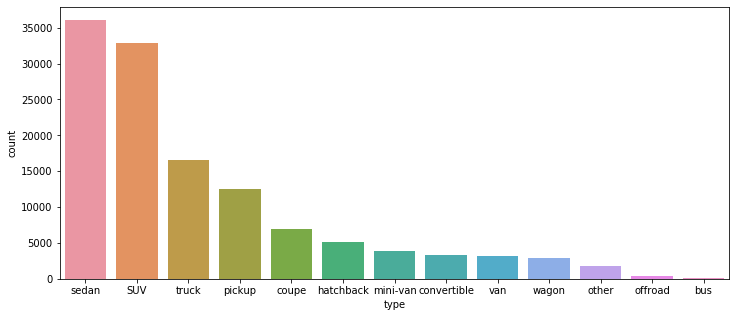

In [58]:
plt.figure(figsize = (12,5))
sns.countplot(x = 'type', order = Final_data['type'].value_counts().index, data = Final_data)

__People are selling the used Sedan the most followed by SUV and Trucks. They are very less likely to sell Bus and off-road vehicles because customer dont buy those often.__

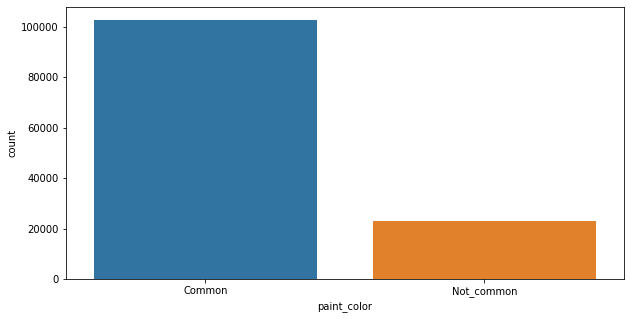

In [59]:
plt.figure(figsize = (10,5))
sns.countplot(x = 'paint_color', order = Final_data['paint_color'].value_counts().index,data = Final_data)

1. __We can see that people are buying used cars with common colors(white,grey,black,silver,blue,red) than not common colors__
2. __Not Common colors (purple, orange, green etc) are mostly luxury cars which are too expensive__

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

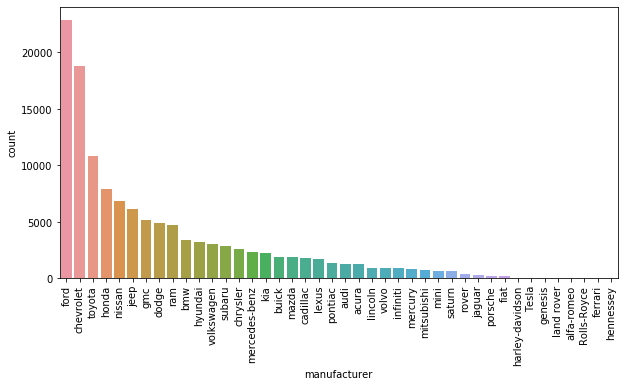

In [60]:
plt.figure(figsize = (10,5))
sns.countplot(x = 'manufacturer', order = Final_data['manufacturer'].value_counts().index, data = Final_data)
plt.xticks(rotation = 90)

__Ford, Toyota, Chevrolet and Honda__ manufacturer cover most of the used cars because they are cheap and good than other manufacturers like __Ferrari, Rolls-Royce and Hennessey__

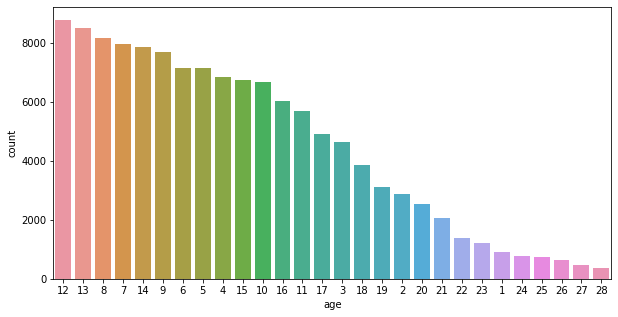

In [61]:
plt.figure(figsize = (10,5))
sns.countplot(x = 'age', order = Final_data['age'].value_counts().index, data = Final_data)

In [63]:
# # using log to convert the skewed to normal distribution of price column becuase regression models performs well 
# with normally distributed target
# Final_data['price'] = np.log(Final_data['price'])
# Final_data['word_len'] = np.log(Final_data['word_len'])

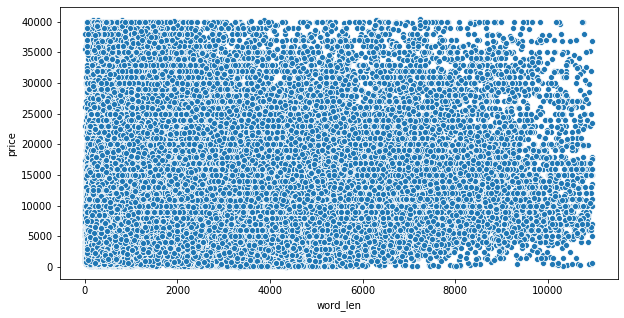

In [92]:
plt.figure(figsize = (10,5))
sns.scatterplot('word_len', 'price', data = Final_data)

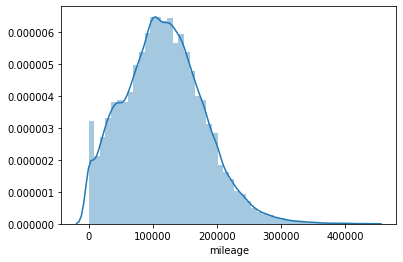

In [93]:
sns.distplot(Final_data['mileage'])

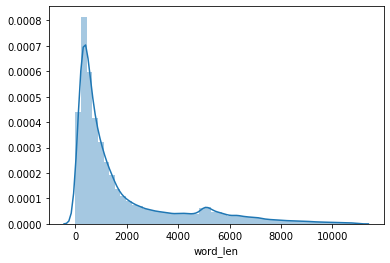

In [94]:
sns.distplot(Final_data['word_len'])

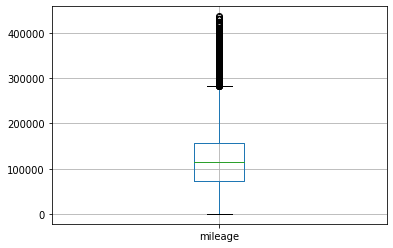

In [95]:
Final_data.boxplot('mileage')

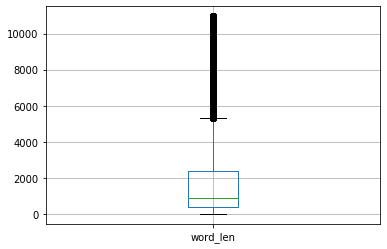

In [96]:
Final_data.boxplot('word_len')

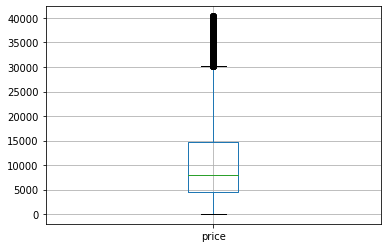

In [97]:
Final_data.boxplot('price')

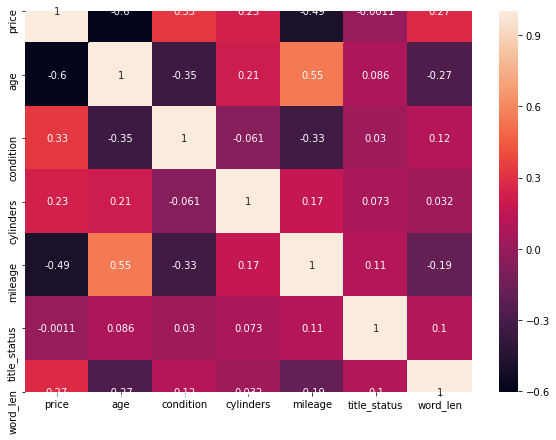

In [98]:
plt.figure(figsize = (10,7))
corr = Final_data.corr()
sns.heatmap(corr, annot = True)

## **Model building**

In [99]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

In [100]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model  import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

In [101]:
F1 = pd.get_dummies(Final_data, drop_first= True)
F1.head()

,price,age,condition,cylinders,mileage,title_status,word_len,manufacturer_Tesla,manufacturer_acura,manufacturer_alfa-romeo,...,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,paint_color_Not_common
0,9000,11,7,8,217743,6,132,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6000,18,7,8,195000,6,505,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,37000,8,8,8,178000,6,274,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,9700,10,7,8,140000,6,483,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2500,19,5,8,220000,6,3657,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [102]:
X = F1.iloc[:, 1:]
y = F1.iloc[:,0:1]

In [103]:
# scaling the inputs
scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)

In [123]:
y = y.ravel()

In [104]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)

In [105]:
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1)

In [106]:
# Algorithms
linreg = LinearRegression()
lasso = Lasso()
ridge = Ridge()
Dtree = DecisionTreeRegressor()
rfreg100 = RandomForestRegressor(n_estimators = 100)

In [107]:
# parameters
kfold = KFold(n_splits = 5)
scoring = 'r2'
algo_list = list([linreg,lasso,ridge,Dtree,rfreg100])
algo_name = list(['linreg','lasso','ridge','Dtree','rfreg100'])

In [108]:
# Buliding models on various algorithms
def model_building(algo,X,y,fold,scoring):
    algo_score = []
    for i in algo:
        score = cross_val_score(i, X, y, cv=fold, scoring=scoring).mean()
        algo_score.append(score)
    return algo_score

In [109]:
result = model_building(algo_list, X_train, y_train, kfold, scoring) # 3:25 pm

In [110]:
cv_score = dict(zip(algo_name,result))

In [111]:
Final_score

{'linreg': -3.2191531620948345e+20,
 'lasso': 0.733601291024901,
 'ridge': 0.7608259838484435,
 'Dtree': 0.7341138060784683,
 'rfreg100': 0.8479036557835258}

In [112]:
def prediction(algo,X_train, y_train, X_test, y_test):
    r2_score1 = []
    for i in algo:
        reg = i.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_score1.append(r2)
    return r2_score1

In [113]:
p = prediction(algo_list, X_train, y_train, X_test, y_test) # 5:25 pm

In [114]:
test_score = dict(zip(algo_name,p))                                                                                             

In [115]:
test_score

{'linreg': 0.761149074547241,
 'lasso': 0.7319624931169314,
 'ridge': 0.7617953491369186,
 'Dtree': 0.7483831110607176,
 'rfreg100': 0.85384119745747}

In [124]:
#since random forest got high accuracy we can finalize the model with that.
rfreg100.fit(X, y) 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [125]:
# saving the model
import joblib

rf_model = 'rf_final_model.sav'
joblib.dump(rfreg100, rf_model)


['rf_final_model.sav']